In [1]:
import sys; sys.path.append("..") 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import *
from src.dataprocessing import *
from src import rnn

# Data

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv')
    cts_list.append(cts_df)
    i += 1

csv file is loaded from ./data/3_continuous/cts_100/dataset 100_1.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_2.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_3.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_4.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_5.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_6.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_7.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_8.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_9.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_10.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_11.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_12.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_13.csv
csv file is loaded from ./data/3_continuous/cts_100/dataset 100_14.csv
csv file is loa

## data to series

In [4]:
target_list = cts_list

history_size = 30
future_size = 10
step = 1

history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

history_series = []
future_series = []

for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                  step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)

print(history_series.shape)
print(future_series.shape)

(30484, 30, 7)
(30484, 10, 3)


## supervised attention

delta 1


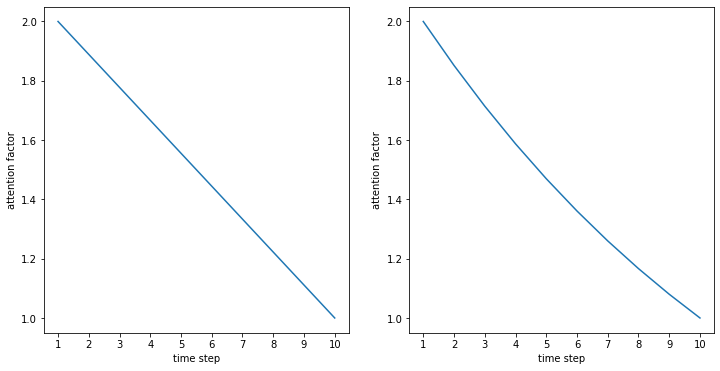

delta 5


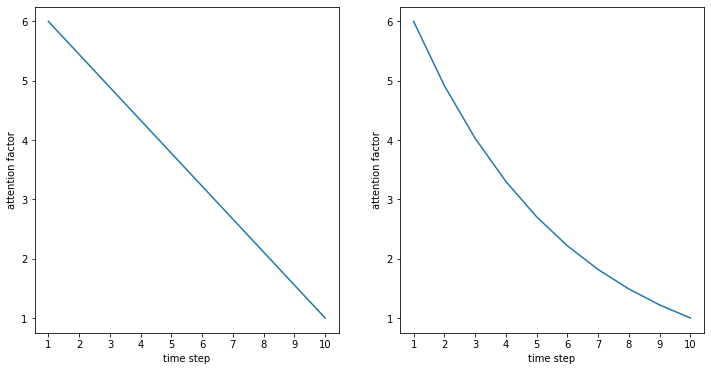

delta 10


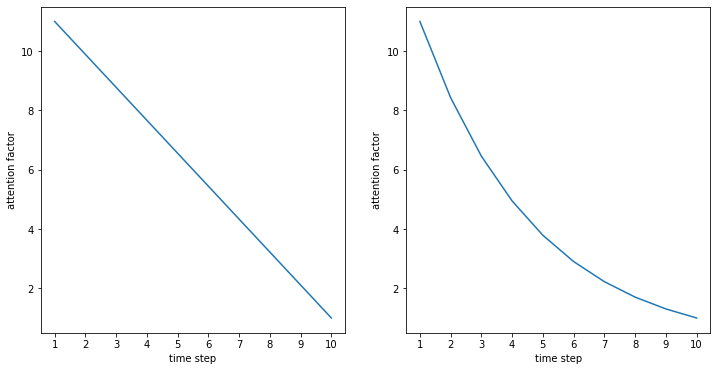

In [5]:
delta_list = [1,5,10]
for delta in delta_list:
    linear_attention = rnn.super_attention(delta, future_size, future_num, 'linear')
    exp_attention = rnn.super_attention(delta, future_size, future_num, 'exp')
    
    print(f"delta {delta}")
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot([x for x in range(1,future_size+1)], linear_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.subplot(1,2,2)
    plt.plot([x for x in range(1,future_size+1)], exp_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.show()

# Build model

In [6]:
Update = False

## seq2seq model

### setting

In [7]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = seq2seq_GRU.history_test.shape[0]/seq2seq_GRU.history_train.shape[0]
seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'seq2seq_gru'
seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type)
print(seq2seq_GRU.model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 50),         8850        ['input_1[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 10, 50)       0           ['encoder[0][0]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 50)       15300       ['repeat_vector[0][0]',      

In [8]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"
update = False

if not exists(f"./model/{model_name}.h5") or update or Update:
    seq2seq_GRU.train()
    seq2seq_GRU.save_model(f"./model/{model_name}", 'weights')
else:
    seq2seq_GRU.model.load_weights(f"./model/{model_name}.h5")

Epoch 1/10000
572/572 - 11s - loss: 0.1130 - val_loss: 0.0769 - 11s/epoch - 18ms/step
Epoch 2/10000
572/572 - 6s - loss: 0.0752 - val_loss: 0.0715 - 6s/epoch - 10ms/step
Epoch 3/10000
572/572 - 7s - loss: 0.0698 - val_loss: 0.0654 - 7s/epoch - 12ms/step
Epoch 4/10000
572/572 - 7s - loss: 0.0670 - val_loss: 0.0712 - 7s/epoch - 11ms/step
Epoch 5/10000
572/572 - 6s - loss: 0.0636 - val_loss: 0.0604 - 6s/epoch - 11ms/step
Epoch 6/10000
572/572 - 6s - loss: 0.0606 - val_loss: 0.0583 - 6s/epoch - 11ms/step
Epoch 7/10000
572/572 - 6s - loss: 0.0577 - val_loss: 0.0556 - 6s/epoch - 11ms/step
Epoch 8/10000
572/572 - 6s - loss: 0.0552 - val_loss: 0.0538 - 6s/epoch - 10ms/step
Epoch 9/10000
572/572 - 6s - loss: 0.0525 - val_loss: 0.0519 - 6s/epoch - 11ms/step
Epoch 10/10000
572/572 - 6s - loss: 0.0498 - val_loss: 0.0487 - 6s/epoch - 11ms/step
Epoch 11/10000
572/572 - 7s - loss: 0.0479 - val_loss: 0.0499 - 7s/epoch - 11ms/step
Epoch 12/10000
572/572 - 7s - loss: 0.0458 - val_loss: 0.0467 - 7s/epoch

### result

In [9]:
_ = seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.908588,0.934201,0.927679,0.923489,4.907098,4.505833,4.152923,4.521951
1,0.816664,0.859924,0.877354,0.851314,6.903264,6.575068,5.407229,6.295187
2,0.712571,0.79539,0.824089,0.77735,8.523756,7.947361,6.475304,7.648807
3,0.611092,0.753418,0.786633,0.717048,9.781327,8.725617,7.131502,8.546149
4,0.514205,0.724803,0.764862,0.667957,10.823522,9.219239,7.486298,9.176353
5,0.427091,0.704506,0.742034,0.624544,11.640243,9.554619,7.841346,9.678736
6,0.349133,0.690978,0.721168,0.587093,12.289669,9.771575,8.152692,10.071312
7,0.278889,0.679934,0.711676,0.556833,12.907416,9.944916,8.291036,10.381123
8,0.212977,0.666865,0.705969,0.528604,13.50334,10.146203,8.373243,10.674262


### prediction plot

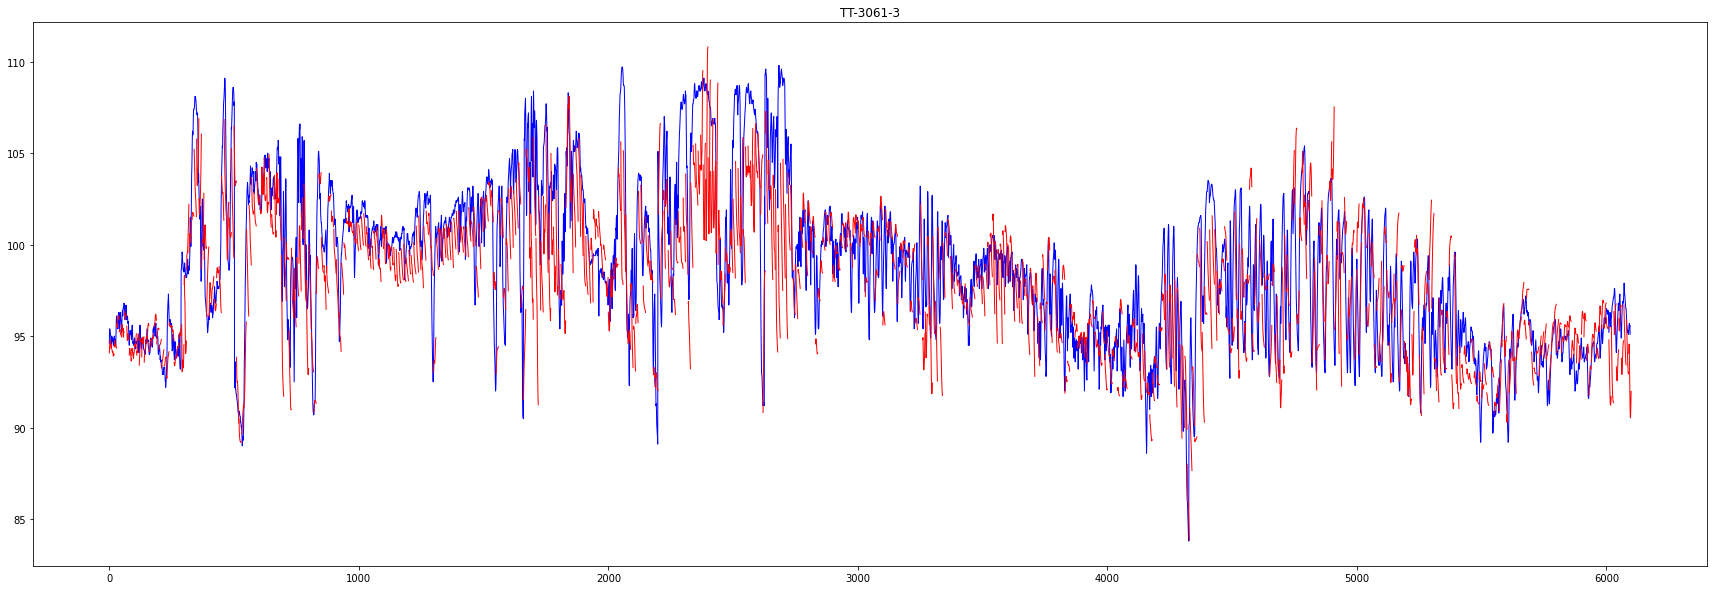

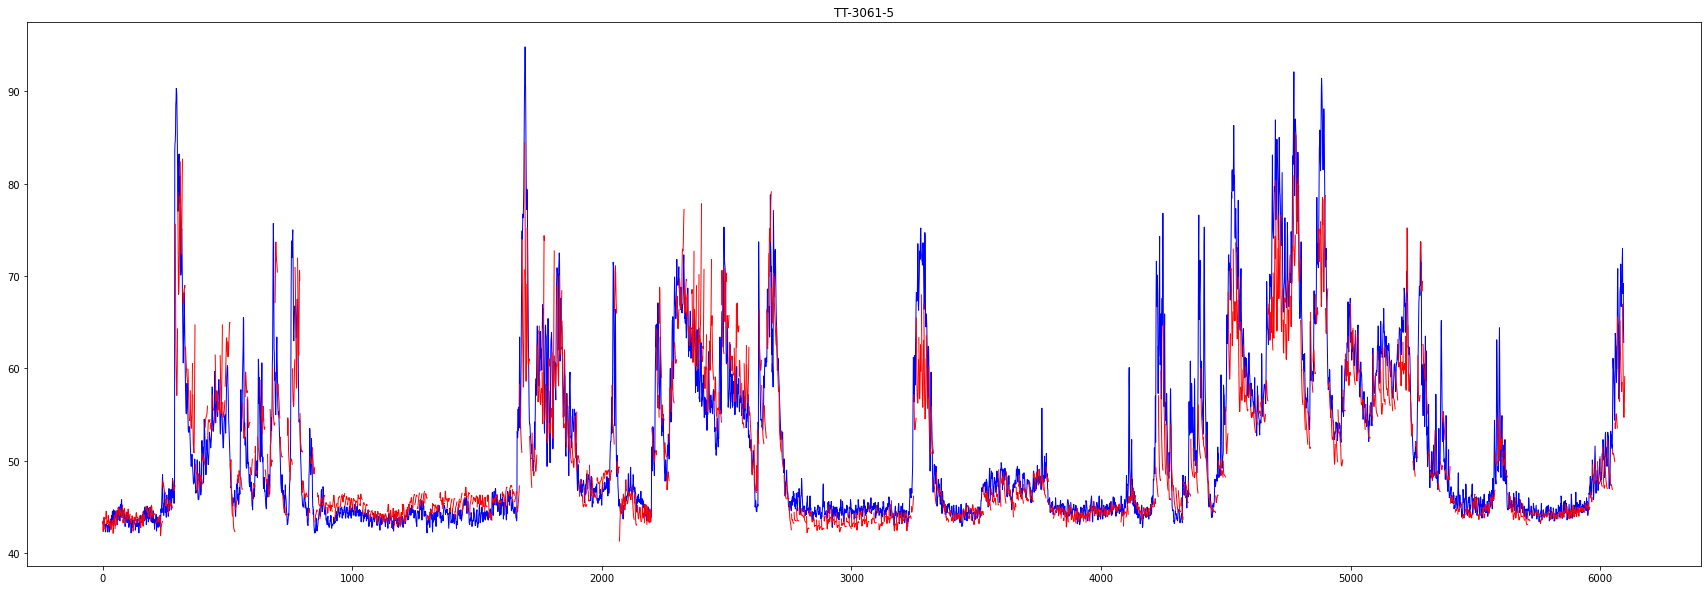

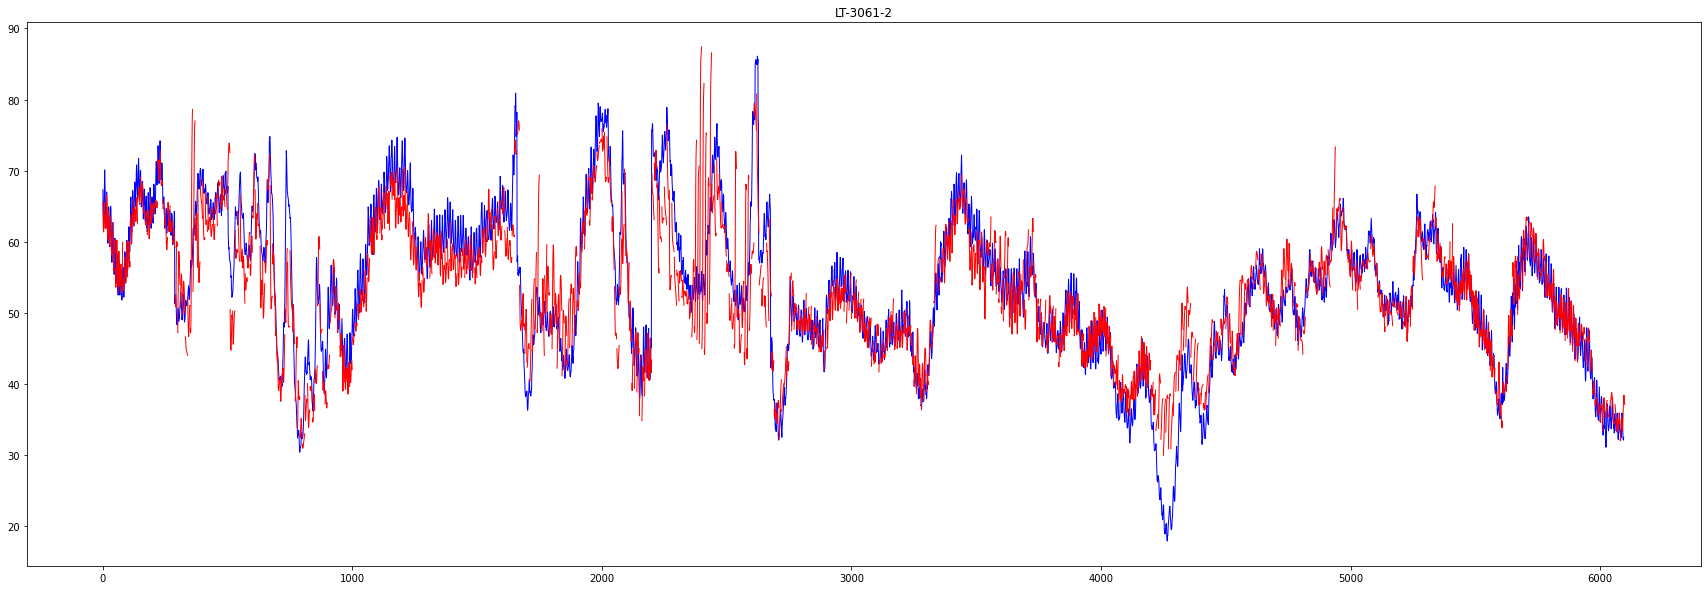

In [10]:
for var_num in range(len(future_var)):
    predict_sc = seq2seq_GRU.model.predict(seq2seq_GRU.history_test_sc)
    actual_sc = seq2seq_GRU.future_test_sc
    _, predict = seq2seq_GRU.unscaling(seq2seq_GRU.history_test_sc, predict_sc)
    _, actual = seq2seq_GRU.unscaling(seq2seq_GRU.history_test_sc, actual_sc)

    plt.figure(figsize=(30,10))
    plt.plot(np.arange(0,len(actual)), actual[:,0,var_num], label='actual', linewidth=1, color='b')

    for start_idx in range(0, len(predict), future_size):
        end_idx = start_idx + future_size
        predict_plot = predict[start_idx, :, var_num]
        plt.plot(np.arange(start_idx, start_idx + len(predict_plot)), predict_plot, label='prediction', linewidth=1, color='r')
    plt.title(f'{future_var[var_num]}')
    plt.show()
    

## attention model

### setting

In [11]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
ATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
ATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = ATT_seq2seq_GRU.history_test.shape[0]/ATT_seq2seq_GRU.history_train.shape[0]
ATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
ATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'att_seq2seq_gru'
ATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(ATT_seq2seq_GRU.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 30, 50),     8850        ['input_2[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 10, 50)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 50)       15300       ['repeat_vector_1[0][0]',  

In [12]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists(f"./model/{model_name}.h5"):
    ATT_seq2seq_GRU.train()
    ATT_seq2seq_GRU.save_model(f"./model/{model_name}", 'weights')
else:
    ATT_seq2seq_GRU.model.load_weights(f"./model/{model_name}.h5")

Epoch 1/10000
572/572 - 12s - loss: 0.1086 - val_loss: 0.0760 - 12s/epoch - 21ms/step
Epoch 2/10000
572/572 - 8s - loss: 0.0742 - val_loss: 0.0691 - 8s/epoch - 13ms/step
Epoch 3/10000
572/572 - 7s - loss: 0.0692 - val_loss: 0.0656 - 7s/epoch - 13ms/step
Epoch 4/10000
572/572 - 7s - loss: 0.0653 - val_loss: 0.0612 - 7s/epoch - 12ms/step
Epoch 5/10000
572/572 - 8s - loss: 0.0621 - val_loss: 0.0597 - 8s/epoch - 15ms/step
Epoch 6/10000
572/572 - 8s - loss: 0.0593 - val_loss: 0.0562 - 8s/epoch - 13ms/step
Epoch 7/10000
572/572 - 7s - loss: 0.0566 - val_loss: 0.0544 - 7s/epoch - 12ms/step
Epoch 8/10000
572/572 - 8s - loss: 0.0542 - val_loss: 0.0520 - 8s/epoch - 14ms/step
Epoch 9/10000
572/572 - 7s - loss: 0.0512 - val_loss: 0.0499 - 7s/epoch - 13ms/step
Epoch 10/10000
572/572 - 7s - loss: 0.0486 - val_loss: 0.0521 - 7s/epoch - 12ms/step
Epoch 11/10000
572/572 - 8s - loss: 0.0474 - val_loss: 0.0457 - 8s/epoch - 14ms/step
Epoch 12/10000
572/572 - 7s - loss: 0.0447 - val_loss: 0.0450 - 7s/epoch

### result

In [13]:
_ = ATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.934359,0.939394,0.944539,0.939431,4.158236,4.324365,3.636753,4.039784
1,0.876573,0.887623,0.921315,0.89517,5.664154,5.889216,4.331057,5.294809
2,0.792552,0.833711,0.887188,0.837817,7.241359,7.164573,5.185505,6.530479
3,0.692645,0.788087,0.853107,0.777946,8.695497,8.088994,5.917229,7.56724
4,0.590843,0.755501,0.82899,0.725111,9.933146,8.689837,6.384351,8.335778
5,0.496626,0.73612,0.816733,0.68316,10.910996,9.029054,6.609237,8.849763
6,0.41553,0.723542,0.812949,0.650674,11.645952,9.242392,6.677442,9.188595
7,0.346904,0.713195,0.813029,0.624376,12.283627,9.414019,6.676601,9.458082
8,0.288702,0.702464,0.814024,0.60173,12.837284,9.58878,6.659266,9.69511


### attention score

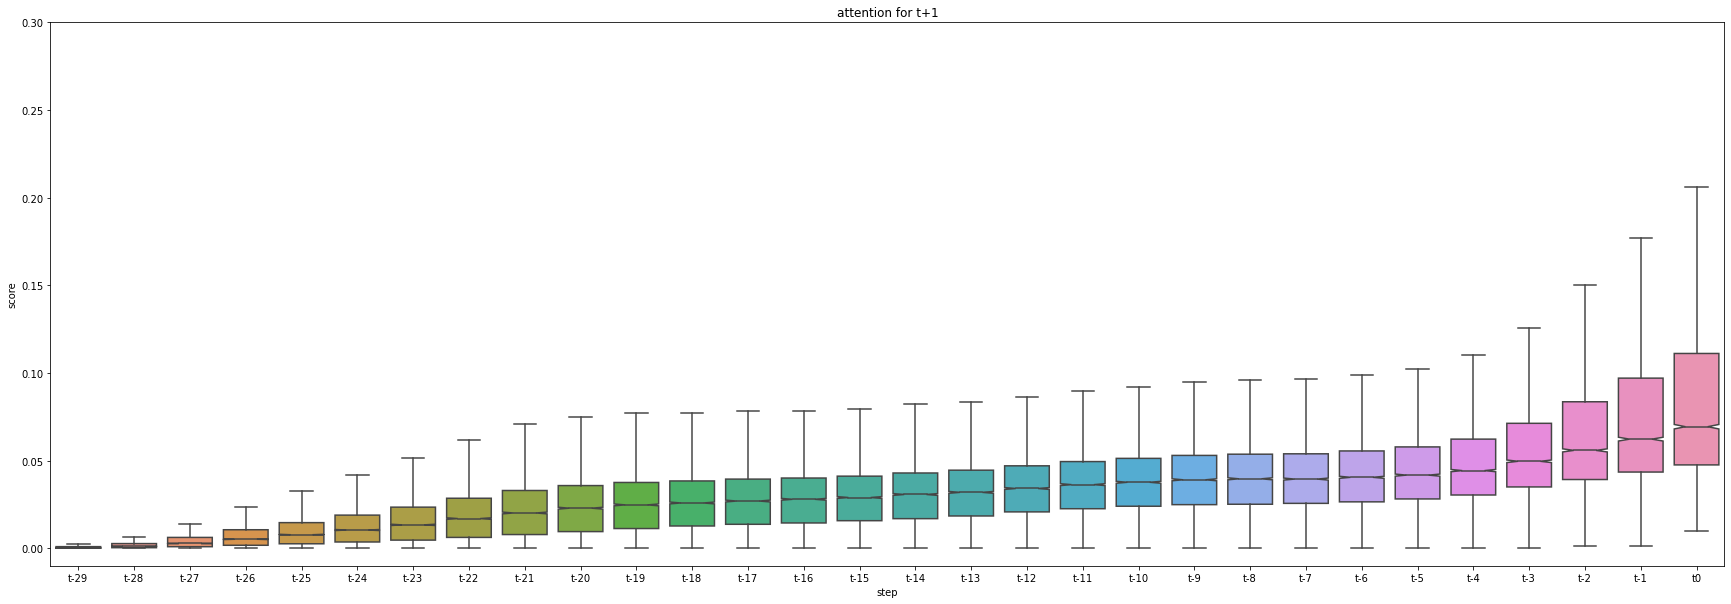

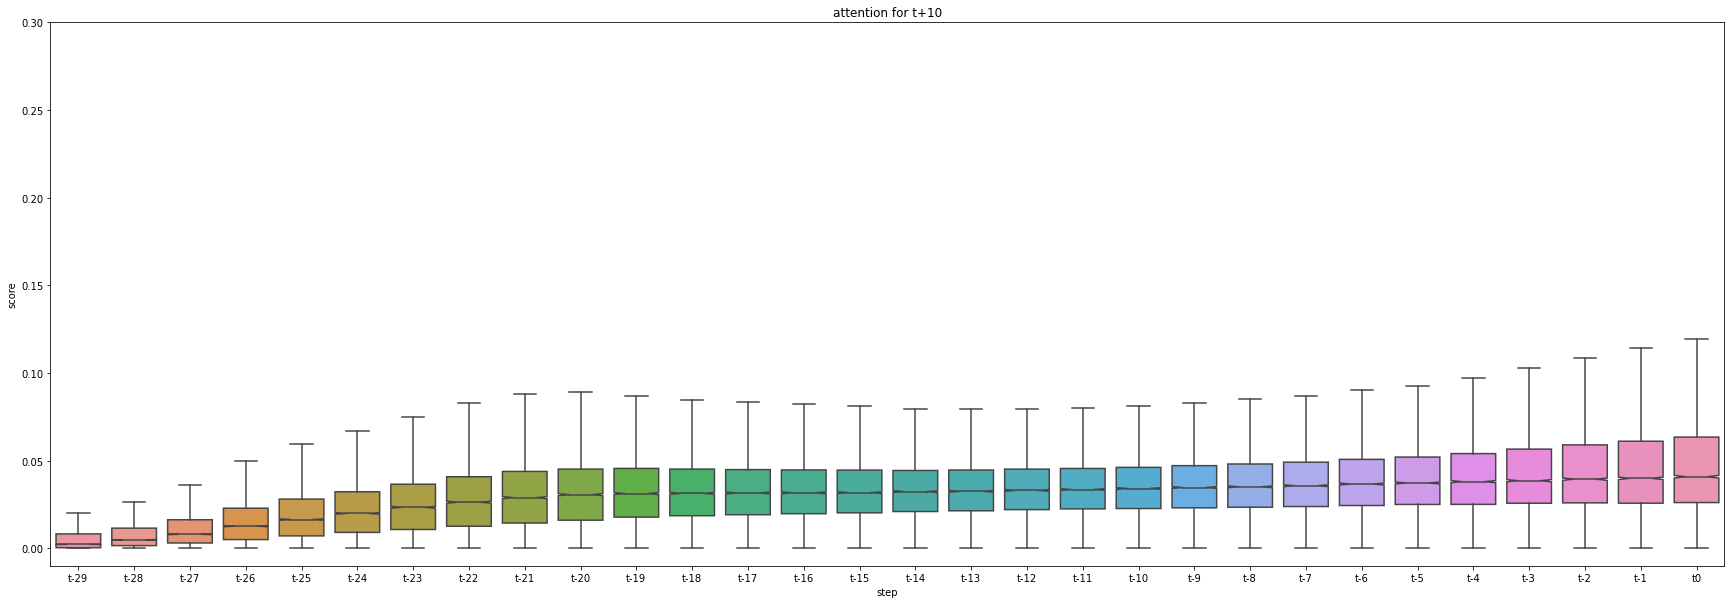

In [14]:
attention = ATT_seq2seq_GRU.get_attention(ATT_seq2seq_GRU.history_test_sc)
plot_steps = [0, 9]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    plt.ylim(-0.01, 0.3)
    plt.title(f"attention for t+{future_step+1}")
    plt.show()

### prediction plot

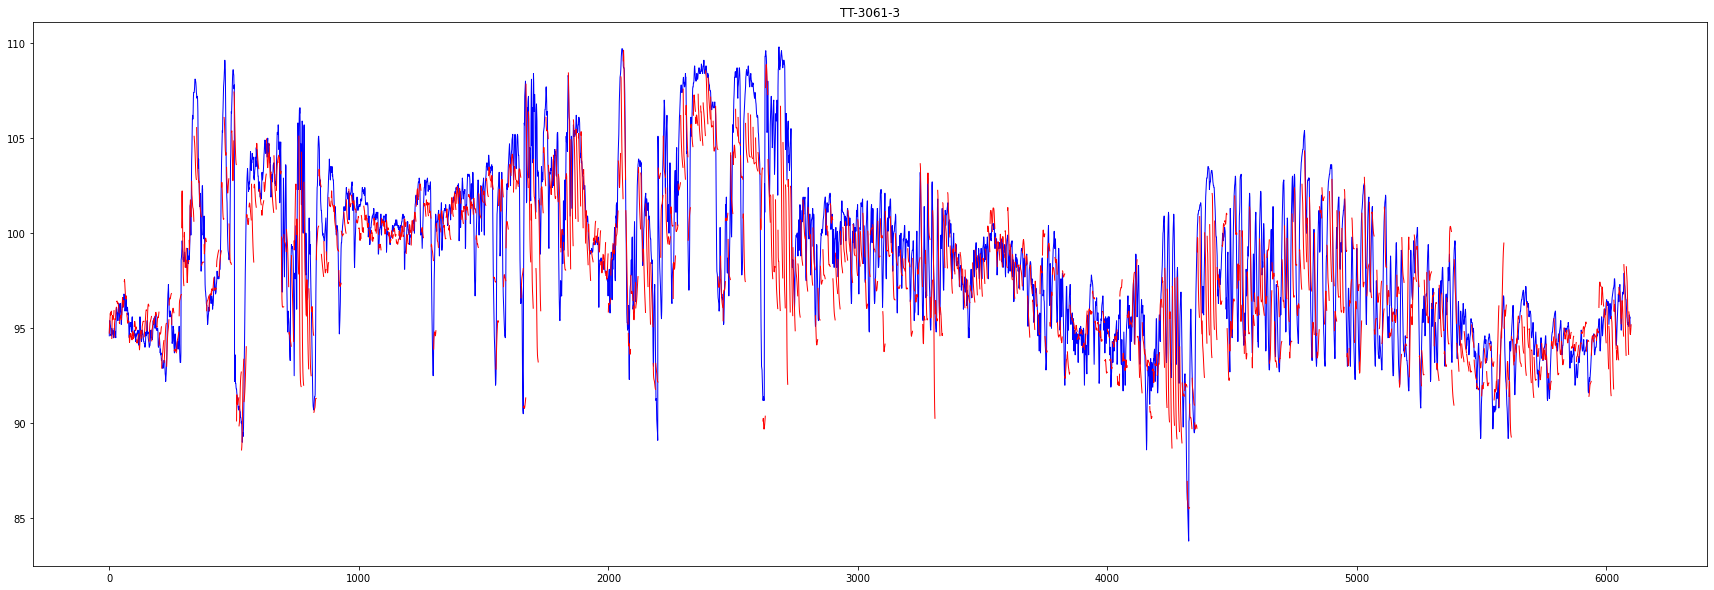

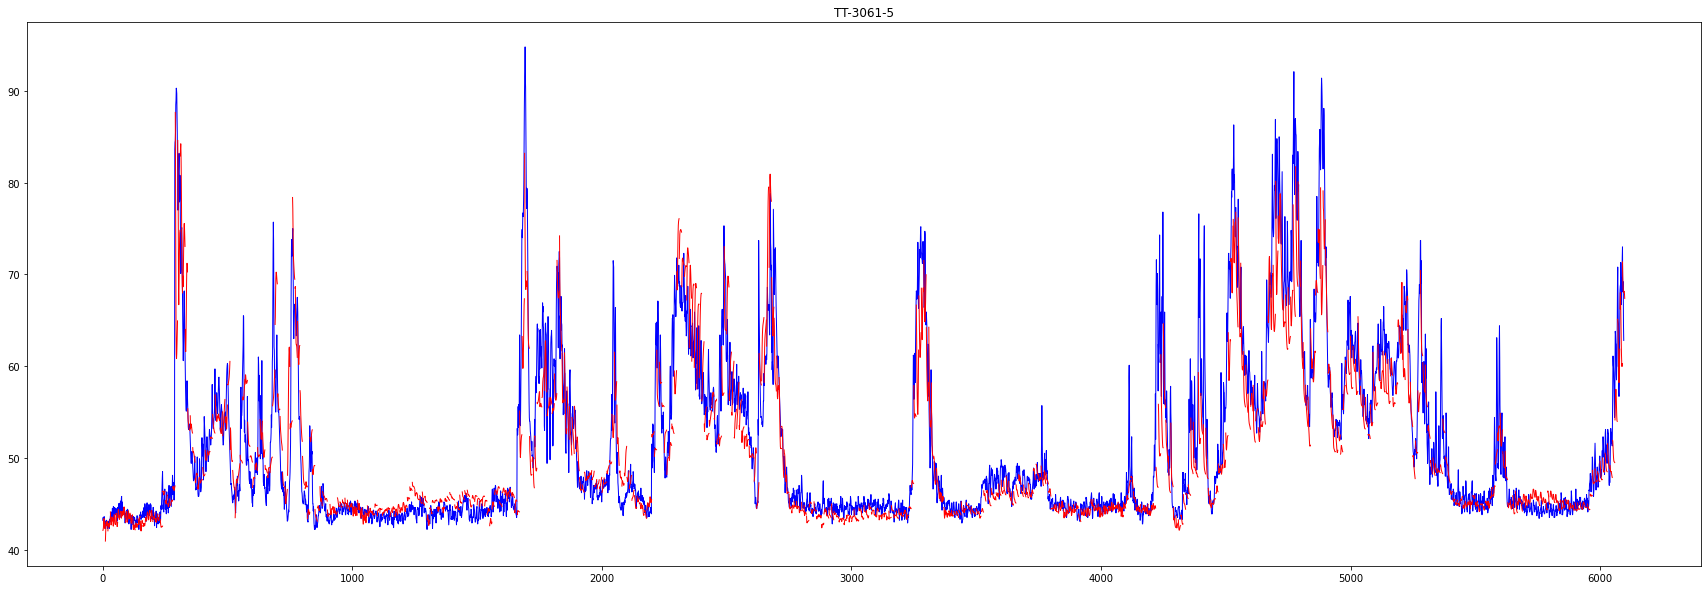

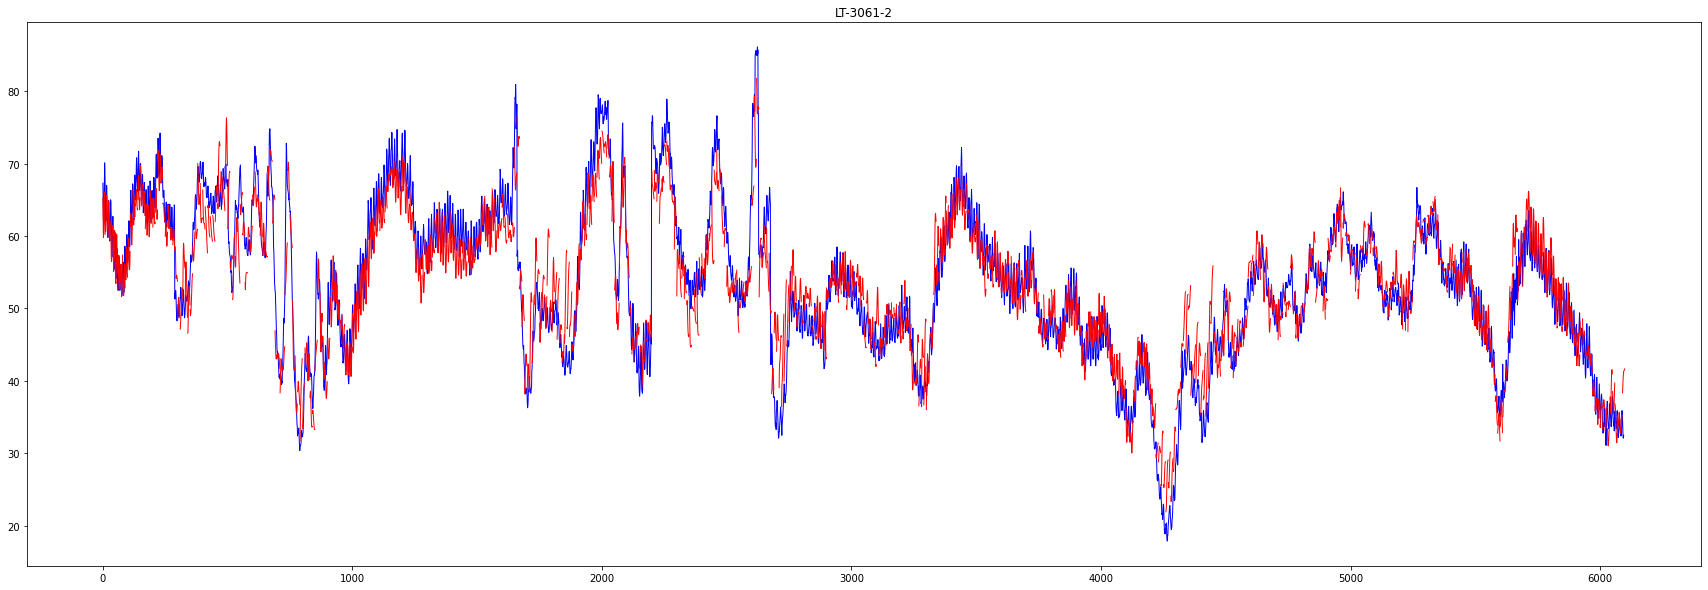

In [15]:
for var_num in range(len(future_var)):
    predict_sc = ATT_seq2seq_GRU.model.predict(ATT_seq2seq_GRU.history_test_sc)
    actual_sc = ATT_seq2seq_GRU.future_test_sc
    _, predict = ATT_seq2seq_GRU.unscaling(ATT_seq2seq_GRU.history_test_sc, predict_sc)
    _, actual = ATT_seq2seq_GRU.unscaling(ATT_seq2seq_GRU.history_test_sc, actual_sc)

    plt.figure(figsize=(30,10))
    plt.plot(np.arange(0,len(actual)), actual[:,0,var_num], label='actual', linewidth=1, color='b')

    for start_idx in range(0, len(predict), future_size):
        end_idx = start_idx + future_size
        predict_plot = predict[start_idx, :, var_num]
        plt.plot(np.arange(start_idx, start_idx + len(predict_plot)), predict_plot, label='prediction', linewidth=1, color='r')
    plt.title(f'{future_var[var_num]}')
    plt.show()

## dual attention model

### setting

In [16]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 30, 50),     8850        ['input_3[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 10, 50)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 50)       15300       ['repeat_vector_2[0][0]',  

In [17]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"
update = True

if not exists(f"./model/{model_name}.h5"):
    DATT_seq2seq_GRU.train()
    DATT_seq2seq_GRU.save_model(f"./model/{model_name}", 'weights')
else:
    DATT_seq2seq_GRU.model.load_weights(f"./model/{model_name}.h5")

Epoch 1/10000
572/572 - 10s - loss: 0.2310 - val_loss: 0.1540 - 10s/epoch - 17ms/step
Epoch 2/10000
572/572 - 6s - loss: 0.1495 - val_loss: 0.1398 - 6s/epoch - 11ms/step
Epoch 3/10000
572/572 - 6s - loss: 0.1379 - val_loss: 0.1304 - 6s/epoch - 11ms/step
Epoch 4/10000
572/572 - 6s - loss: 0.1292 - val_loss: 0.1202 - 6s/epoch - 11ms/step
Epoch 5/10000
572/572 - 6s - loss: 0.1203 - val_loss: 0.1123 - 6s/epoch - 11ms/step
Epoch 6/10000
572/572 - 6s - loss: 0.1115 - val_loss: 0.1079 - 6s/epoch - 11ms/step
Epoch 7/10000
572/572 - 6s - loss: 0.1047 - val_loss: 0.1018 - 6s/epoch - 11ms/step
Epoch 8/10000
572/572 - 6s - loss: 0.1012 - val_loss: 0.0974 - 6s/epoch - 11ms/step
Epoch 9/10000
572/572 - 6s - loss: 0.0981 - val_loss: 0.0967 - 6s/epoch - 11ms/step
Epoch 10/10000
572/572 - 6s - loss: 0.0946 - val_loss: 0.0960 - 6s/epoch - 11ms/step
Epoch 11/10000
572/572 - 6s - loss: 0.0914 - val_loss: 0.0906 - 6s/epoch - 11ms/step
Epoch 12/10000
572/572 - 6s - loss: 0.0888 - val_loss: 0.0881 - 6s/epoch

### result

In [18]:
_ = DATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.927699,0.930513,0.957741,0.938651,4.364105,4.630379,3.174557,4.056347
1,0.844136,0.874984,0.916807,0.878642,6.365068,6.211569,4.453403,5.67668
2,0.708123,0.816283,0.862432,0.795613,8.589456,7.530679,5.726271,7.282135
3,0.550609,0.770291,0.812047,0.710982,10.514453,8.421795,6.69333,8.543192
4,0.398224,0.740557,0.777042,0.638608,12.046464,8.951458,7.28983,9.429251
5,0.256227,0.720073,0.757651,0.577984,13.262928,9.29954,7.600279,10.054249
6,0.132118,0.703751,0.745807,0.527225,14.191371,9.567502,7.784162,10.514345
7,0.032827,0.69054,0.738514,0.487294,14.948242,9.778752,7.895731,10.874242
8,-0.039525,0.681983,0.73603,0.459496,15.519044,9.913312,7.933688,11.122015


### attention score

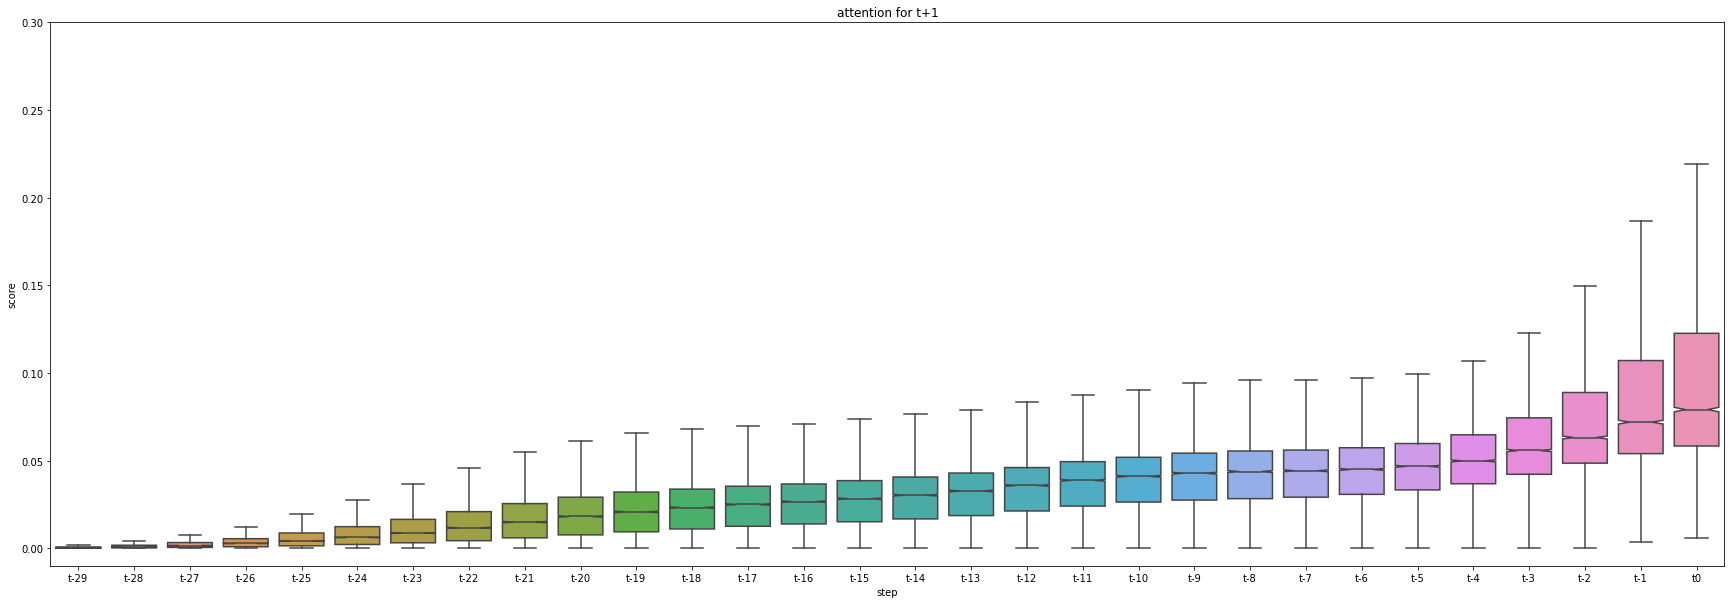

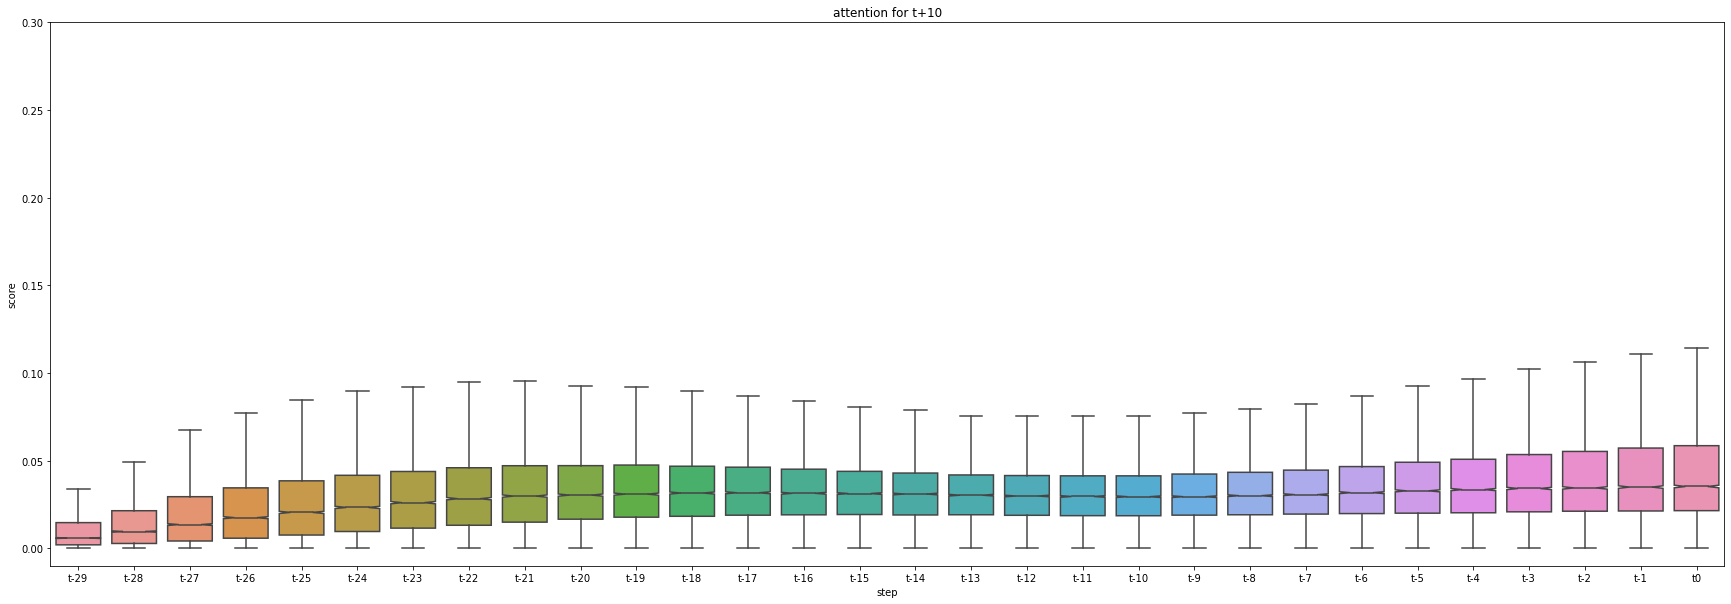

In [19]:
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
plot_steps = [0,9]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    plt.ylim(-0.01, 0.3)
    plt.title(f"attention for t+{future_step+1}")
    plt.show()

### prediction plot

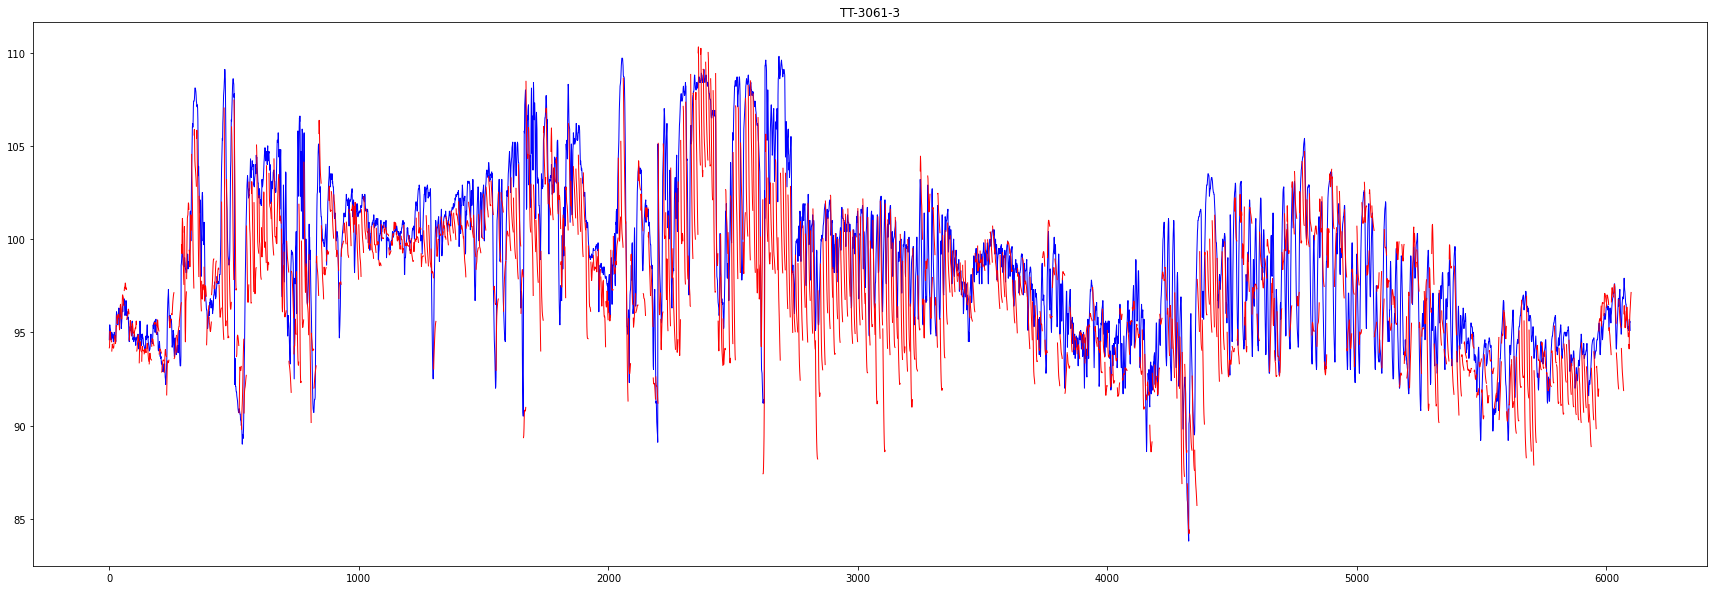

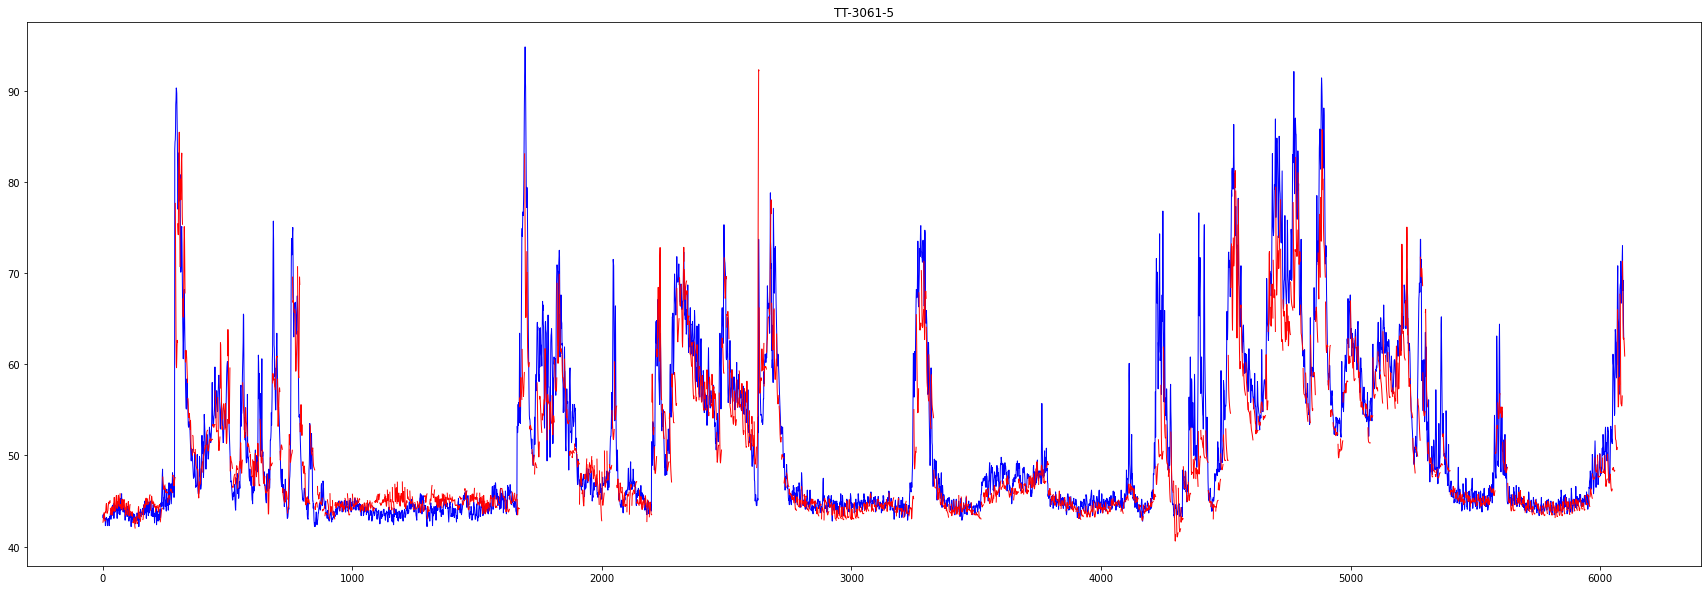

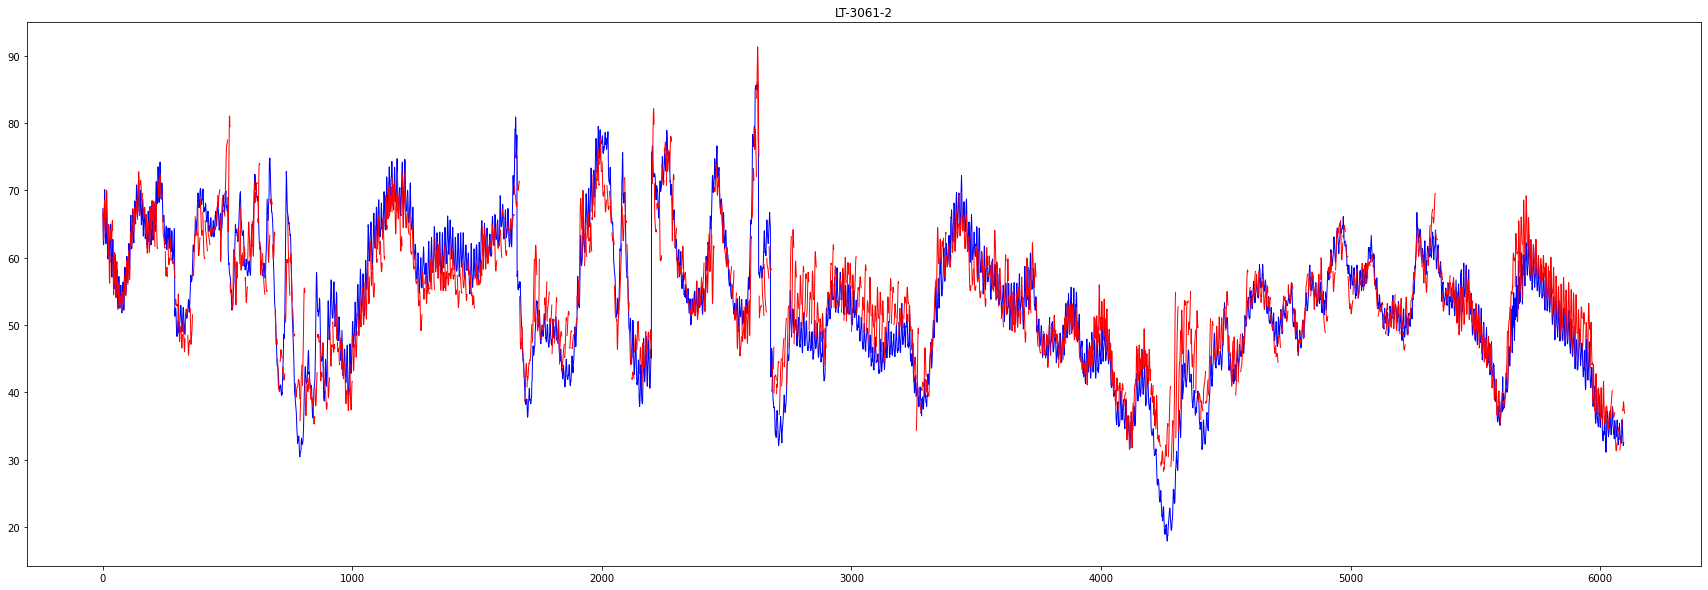

In [20]:
for var_num in range(len(future_var)):
    predict_wt = DATT_seq2seq_GRU.model.predict(DATT_seq2seq_GRU.history_test_sc)
    predict_sc = predict_wt/DATT_seq2seq_GRU.factor
    actual_sc = DATT_seq2seq_GRU.future_test_sc
    _, predict = DATT_seq2seq_GRU.unscaling(DATT_seq2seq_GRU.history_test_sc, predict_sc)
    _, actual = DATT_seq2seq_GRU.unscaling(DATT_seq2seq_GRU.history_test_sc, actual_sc)

    plt.figure(figsize=(30,10))
    plt.plot(np.arange(0,len(actual)), actual[:,0,var_num], label='actual', linewidth=1, color='b')

    for start_idx in range(0, len(predict), future_size):
        end_idx = start_idx + future_size
        predict_plot = predict[start_idx, :, var_num]
        plt.plot(np.arange(start_idx, start_idx + len(predict_plot)), predict_plot, label='prediction', linewidth=1, color='r')
    plt.title(f'{future_var[var_num]}')
    plt.show()